# Sheet 11 Leonhard Moske
## Exercise 30

In [2]:
import numpy as np

def convert2mps(x,chi,L):
    us = []
    lambdas = []
    vtmp = x
    vshape = (1,2**(L))
    for i in range(1,L):
        u , lam, vtmp = np.linalg.svd(np.reshape(vtmp, (int(vshape[0]*2), int(vshape[1]/2))), full_matrices = False)
        vshape = np.shape(vtmp)
        ushape = np.shape(u)
        us.append(np.reshape(u,(int(ushape[0]/2), 2, ushape[1])))
        lam[chi:] = 0
        lambdas.append(lam)
        # print(np.shape(u), np.shape(lam), np.shape(vtmp))
    us.append(np.reshape(vtmp,(int(vshape[0]), 2, 1)))
    lambdas.append([1])
    As = []
    for i in range(L):
        As.append(us[i] * lambdas[i])
    return As



In [3]:
L = 6
x = np.random.randint(0,16,2**L)
print(x)
# print(np.shape(convert2mps(x, 4, L)[0][1]))
for A in convert2mps(x, 3, L):
    print(np.shape(A))

[13  8  5 15 14 11 15  3  5  5 12  4 13 15 14  3  4  9 11  5  8 12  1 14
  8 12 13 14 13  9  2 14 12  8  7  4  1  0 15  1  2  3  0 11 13  9  9 10
 15  1  3 12  5  5 13  9  6  9  7  0  0  8  4  0]
(1, 2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2, 2, 1)


## Exercise 31

In [4]:
def convert2vetcor(mps, L):
    c = mps[0]
    for i in range(1,L):
        c = np.tensordot(c, mps[i], axes = [1 + i, 0])
    return np.reshape(np.squeeze(np.squeeze(c,axis=0),axis = -1), 2**L)

def overlap(x1, x2):
    return np.sum(x1 * x2)

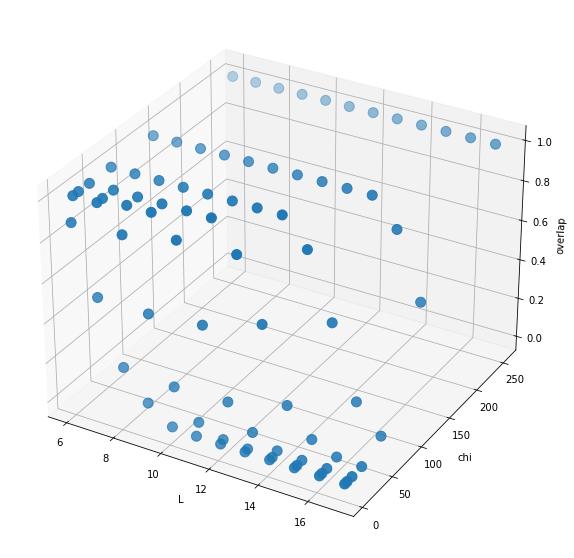

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')

Ls = []
chis = []
over = []


for L in range(6, 18, 1):
    for chi in range(2,9):
        x = np.random.normal(0,1,2**L)
        x /= np.linalg.norm(x)
        xtilde = convert2vetcor(convert2mps(x, 2**chi, L),L)

        Ls.append(L)
        chis.append(2**chi)
        over.append(overlap(x,xtilde))

ax.scatter(Ls,chis, over, s = 100, cmap=cm.coolwarm)

ax.set_xlabel("L")
ax.set_ylabel("chi")
ax.set_zlabel("overlap")
# run this in python script for nice animation
# for angle in range(0, 360):
#     ax.view_init(5, angle)
#     plt.draw()
#     plt.pause(.001)
plt.show()

## Exercise 32

In [8]:
import itertools as it
import numpy as np

def genBasis(L, s): #L number of spins, s total spin
    posSpins = np.linspace(-s, s, int((2*s+1)), dtype = float)#generate List of all possible z projections
    #print("possible Spins ", posSpins)
    tmp = it.product(posSpins, repeat = L) # generate object that itterates over all combinations
    return np.asarray([i for i in tmp]) # assemble the list

def Splus(oldcoef, state, site): # site counted from 0 , passed with copy
                        # return new coefficient and new state 
    if (state[site] == 0.5): #s): # if state is s the operator will return 0
        return 0, np.zeros(L)
    # coef = 1  #s = 1/2 #coef = np.sqrt(s*(s+1) - state[site] * (state[site] + 1)) #calculate new coef
    state[site] = 0.5 #state[site] + 1 # update spin state
    return oldcoef, state 

def Sminus(oldcoef, state, site): # analog to Splus
    if (state[site] == -0.5): # -s ):
        return 0, np.zeros(L)
    # coef = 1 #coef = np.sqrt(s*(s+1) - state[site] * (state[site] - 1))
    state[site] = -0.5 # state[site] - 1
    return oldcoef, state #coef*oldcoef 

def Sz(coef, state, site): 
    return state[site]*coef, state

def Hamiltonian(J, statei, L, statej, s):
    H = 0
    # if (np.array_equal(statei, statej)): # is in HamiltonianDiag
    #     for i in range(L):
    #         H += statei[i]*statei[(i+1)%L] * J
            #H += Sz(*Sz(1, np.copy(statei), (i+1)%L), i)[0] * J
    for i in range(L): #apply the operators to every site until L-1
        coef1, state1 = Splus(*Sminus(1, np.copy(statei),(i+1)%L), i)
        coef2, state2 = Sminus(*Splus(1, np.copy(statei), (i+1)%L), i)
        #coef3, state3 = Sz(*Sz(1, np.copy(statei), i+1), i)
        if np.array_equal(state1, statej): #compare if (<i|H)|j> is 0 for every term
            H += coef1*J*0.5
        if np.array_equal(state2, statej):
            H += coef2*J*0.5
        #if np.array_equal(state3, statej):
        #    H += coef3 * J
    return H

def HamiltonianOpen(J, statei, L, statej, s):
    H = 0
    # if (np.array_equal(statei, statej)): # is in HamiltonianDiag
    #     for i in range(L):
    #         H += statei[i]*statei[(i+1)%L] * J
            #H += Sz(*Sz(1, np.copy(statei), (i+1)%L), i)[0] * J
    for i in range(L-1): #apply the operators to every site until L-1
        coef1, state1 = Splus(*Sminus(1, np.copy(statei),(i+1)%L), i)
        coef2, state2 = Sminus(*Splus(1, np.copy(statei), (i+1)%L), i)
        #coef3, state3 = Sz(*Sz(1, np.copy(statei), i+1), i)
        if np.array_equal(state1, statej): #compare if (<i|H)|j> is 0 for every term
            H += coef1*J*0.5
        if np.array_equal(state2, statej):
            H += coef2*J*0.5
        #if np.array_equal(state3, statej):
        #    H += coef3 * J
    return H

def HamiltonianDiag(J, statei, L):
    H = 0
    for i in range(L):
        H += statei[i]*statei[(i+1)%L] * J
    return H

def HamiltonianDiagOpen(J, statei, L):
    H = 0
    for i in range(L-1):
        H += statei[i]*statei[(i+1)%L] * J
    return H


def calcMatrix(Basis, J, L, s):# calculate the basis by calculating the hamiltonian with all combination from the basis
    Matrix = np.empty((len(Basis),len(Basis)))
    for i in range(len(Basis)):
        Matrix[i,i] = HamiltonianDiag(J, Basis[i], L)
    for i, j in it.permutations(range(len(Basis)), 2):
        Matrix[i,j] = Hamiltonian(J, Basis[i], L, Basis[j], s)
    return Matrix 

def calcMatrixOpen(Basis, J, L, s):# calculate the basis by calculating the hamiltonian with all combination from the basis
    Matrix = np.empty((len(Basis),len(Basis)))
    for i in range(len(Basis)):
        Matrix[i,i] = HamiltonianDiagOpen(J, Basis[i], L)
    for i, j in it.permutations(range(len(Basis)), 2):
        Matrix[i,j] = HamiltonianOpen(J, Basis[i], L, Basis[j], s)
    return Matrix 

def hFields(statei, L, h):
    return np.sum(np.multiply(statei,h))

def calcMatrixOpenWField(Basis, J, L, s, h):# calculate the basis by calculating the hamiltonian with all combination from the basis
    Matrix = np.empty((len(Basis),len(Basis)))
    for i in range(len(Basis)):
        Matrix[i,i] = HamiltonianDiagOpen(J, Basis[i], L) - hFields(Basis[i], L, h)
    for i, j in it.permutations(range(len(Basis)), 2):
        Matrix[i,j] = HamiltonianOpen(J, Basis[i], L, Basis[j], s)  
    return Matrix 

In [9]:
L = 10 # L = 10 5 min
s = 0.5
J = 1

W = 0.5
h = np.random.uniform(low = -W,high=W,size= L)

ham1 = calcMatrixOpenWField(genBasis(L,s),J,L,s,h)

W = 10
h = np.random.uniform(low = -W,high=W,size= L)

ham2 = calcMatrixOpenWField(genBasis(L,s),J,L,s,h)

1024


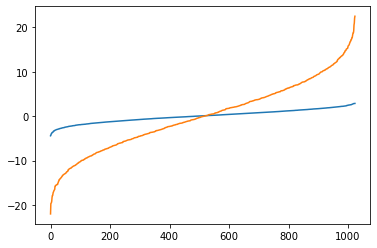

In [10]:
import matplotlib.pyplot as plt
w1, v1 = np.linalg.eig(ham1)
w2, v2 = np.linalg.eig(ham2)


print(len(w1))
plt.plot(sorted(w1))
plt.plot(sorted(w2))
plt.show()

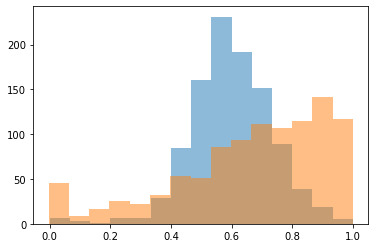

In [36]:
chi = 11

# print(np.shape(v2))

v1over = []
for v in np.transpose(v1):
    # print(overlap(v, convert2vetcor(convert2mps(v, chi, L),L)))
    v1over.append(overlap(v, convert2vetcor(convert2mps(v, chi, L),L)))


v2over = []
for v in np.transpose(v2):
    # print(overlap(v, convert2vetcor(convert2mps(v, chi, L),L)))
    v2over.append(overlap(v, convert2vetcor(convert2mps(v, chi, L),L)))



plt.hist(v1over, alpha = 0.5, bins = 15) # W = 0.5
plt.hist(v2over, alpha = 0.5, bins = 15) # W = 10
plt.show()